In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from ls.config.loader import load_config
import IPython.display as ipd

In [3]:
# --- 1. load config ---
cfg = load_config("../configs/config.yaml")

cfg.keys()

dict_keys(['seed', 'dataset', 'audio', 'models', 'training', 'mlflow'])

In [4]:
from ls.data.dataloaders import build_dataloaders

train_loader, test_loader = build_dataloaders(cfg.dataset, cfg.audio)

[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)
[Transforms] Input spectrogram resize factor: 1.0, target size: (128, 1024)


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


[ICBHI] Extracted 4142 respiratory cycles from 539 recordings
[ICBHI] Input spectrogram shape: (997, 128, 1)
[ICBHI] 4142 cycles (base cycles only, aug handled dynamically)
  Class 0: 2063 (49.8%)
  Class 1: 1215 (29.3%)
  Class 2: 501 (12.1%)
  Class 3: 363 (8.8%)
[ICBHI] Active waveform augmentations: Loudness, VTLP
[ICBHI] Active spectrogram augmentations: SpecAugment
[ICBHI] Expected P(augmented) ≈ 0.43 (~1793/4142 per epoch)


/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


[ICBHI] Extracted 2756 respiratory cycles from 381 recordings
[ICBHI] Input spectrogram shape: (997, 128, 1)
[ICBHI] 2756 cycles (base cycles only, aug handled dynamically)
  Class 0: 1579 (57.3%)
  Class 1: 649 (23.5%)
  Class 2: 385 (14.0%)
  Class 3: 143 (5.2%)
[ICBHI] No waveform augmentations
[ICBHI] No spectrogram augmentations


In [5]:
for batch in train_loader:
    X_batch, y_batch = batch["input_values"], batch["label"]
    break

/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [6]:
X_batch.shape, y_batch.shape, type(X_batch), type(y_batch)

(torch.Size([32, 1, 128, 1024]), torch.Size([32]), torch.Tensor, torch.Tensor)

In [7]:
X_batch.min(), X_batch.max(), y_batch.min(), y_batch.max()

(tensor(-2.5552), tensor(2.0540), tensor(0), tensor(3))

tensor(1)


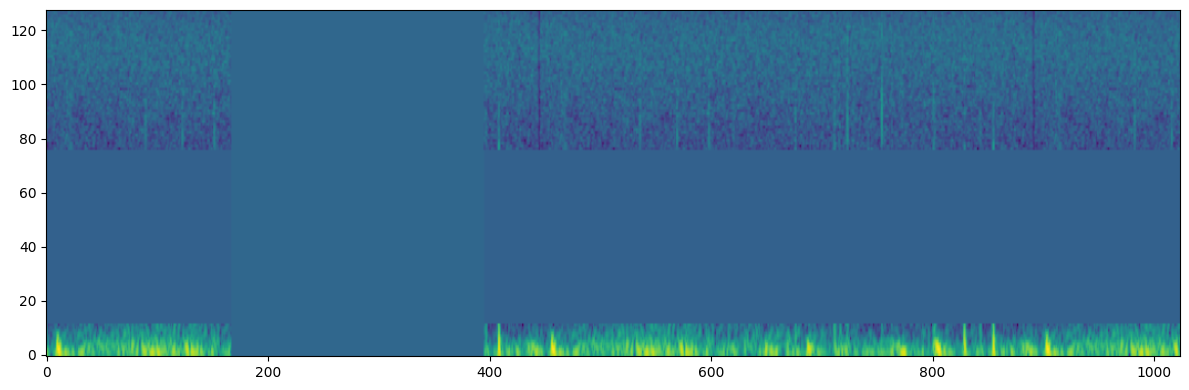

In [8]:
import matplotlib.pyplot as plt
idx = 1
print(y_batch[idx])
plt.figure(figsize=(12, 4))
plt.imshow(X_batch[idx].squeeze(0).numpy(), aspect='auto', origin='lower'), y_batch[idx]
plt.tight_layout()
plt.show()

In [9]:
from ls.engine.train import get_loss
from ls.models.builder import build_model

In [10]:
from ls.engine.utils import get_device

DEVICE = get_device()
DEVICE

[Device] Using Apple Metal (MPS) acceleration


device(type='mps')

In [11]:
cnn_model = build_model(cfg.models, model_key="cnn6")

print(f"Using device: {DEVICE}")

cnn_model = cnn_model.to(DEVICE)
print(cnn_model)

Building model 'cnn6' with config: {'do_dropout': True, 'label_dim': 4, 'backbone_only': False, 'cpt_path': '/Users/gkont/Documents/Code/pretrained_models/Cnn6_mAP=0.343.pth'}
Using device: mps
CNN6(
  (conv_block1): ConvBlock5x5(
    (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): ConvBlock5x5(
    (conv1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block3): ConvBlock5x5(
    (conv1): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block4): ConvBlock5x5(
    (conv1): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (bn1): BatchNorm2

In [12]:
for p in cnn_model.parameters():
    print(p.shape, p.numel())
print(f"Total number of parameters: {sum(p.numel() for p in cnn_model.parameters())}")

torch.Size([64, 1, 5, 5]) 1600
torch.Size([64]) 64
torch.Size([64]) 64
torch.Size([128, 64, 5, 5]) 204800
torch.Size([128]) 128
torch.Size([128]) 128
torch.Size([256, 128, 5, 5]) 819200
torch.Size([256]) 256
torch.Size([256]) 256
torch.Size([512, 256, 5, 5]) 3276800
torch.Size([512]) 512
torch.Size([512]) 512
torch.Size([4, 512]) 2048
torch.Size([4]) 4
Total number of parameters: 4306372


In [13]:
ast_model = build_model(cfg.models, model_key="ast")

print(f"Using device: {DEVICE}")

ast_model = ast_model.to(DEVICE)
print(ast_model)

Building model 'ast' with config: {'audioset_pretrain': True, 'input_fdim': 128, 'input_tdim': 1024, 'model_size': 'base384', 'fstride': 10, 'tstride': 10, 'imagenet_pretrain': True, 'label_dim': 4, 'backbone_only': False, 'audioset_ckpt_path': '/Users/gkont/Documents/Code/pretrained_models/audioset_10_10_0.4593.pth'}
---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
Loading AudioSet pretrained model from /Users/gkont/Documents/Code/pretrained_models/audioset_10_10_0.4593.pth
Vision transformer model size base384 created.
frequncey stride=10, time stride=10
number of patches=1212
Using device: mps
ASTModel(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attenti

In [14]:
print(f"Total number of parameters: {sum(p.numel() for p in ast_model.parameters())}")

Total number of parameters: 87729876


In [15]:
from ls.engine.utils import set_seed

set_seed(cfg.seed)

[Seed] Fixed all random seeds to 42 (MPS)


In [16]:
mlflow_cfg = load_config("../configs/mlflow.yaml")

In [17]:
import os
from ls.engine.logging_utils import get_or_create_experiment
import mlflow

# Authenticate with MLflow
os.environ["MLFLOW_TRACKING_USERNAME"] = mlflow_cfg.tracking_username
os.environ["MLFLOW_TRACKING_PASSWORD"] = mlflow_cfg.tracking_password

# Set the MLflow tracking URI
mlflow.set_tracking_uri(mlflow_cfg.tracking_uri)

# Set a default experiment
mlflow.set_experiment(experiment_id=get_or_create_experiment(mlflow_cfg.experiment_name))

<Experiment: artifact_location='mlflow-artifacts:/21', creation_time=1759607904073, experiment_id='21', last_update_time=1759607904073, lifecycle_stage='active', name='[KON] - ICBHI - AST', tags={}>

In [18]:
from ls.engine.train import train_loop

In [19]:
cfg.training.keys()

dict_keys(['loss', 'use_class_weights', 'epochs', 'optimizer', 'scheduler'])

In [20]:
print(cfg.training.optimizer)
print(cfg.training.scheduler)

{'type': 'adamw', 'lr': '3e-5', 'weight_decay': 0.05}
{'type': 'cosine', 'warmup_epochs': 10, 'start_linear_warmup': '1e-3', 'end_linear_warmup': 1.0, 'min_lr': '1e-8', 'cosine_weight_decay': True, 'final_weight_decay': 0.0, 'reduce_factor': 0.5, 'reduce_patience': 5, 'reduce_min_lr': '1e-8', 'reduce_metric': 'icbhi_score', 'reduce_mode': 'max'}


In [21]:
# Start MLflow experiment
# mlflow.set_experiment(cfg.experiment.name)
run_name = f"{cfg.model.name}_{cfg.training.epochs}epochs_single"
with mlflow.start_run(run_name=run_name):
    mlflow.log_params({
        "model": cfg.model.name,
        "epochs": cfg.training.epochs,
        "batch_size": cfg.dataset.batch_size,
        "loss": cfg.training.loss,
        "dataset_split": cfg.dataset.split_strategy
    })

    train_loop(cfg.training, cnn_model, train_loader, val_loader=test_loader)
    mlflow.end_run()

[Device] Using Apple Metal (MPS) acceleration
[INFO] Using dynamically computed class weights: [0.5019999742507935, 0.8519999980926514, 2.066999912261963, 2.8529999256134033]
Using Scheduler: cosine


[Train][Epoch 1]:   0%|          | 0/129 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniconda/base/envs/icbhi-ast/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🏃 View run {}_100epochs_single at: https://exp.iotlab.ceid.upatras.gr/#/experiments/21/runs/d4c6612cd3954217b8193b39a6fb84e5
🧪 View experiment at: https://exp.iotlab.ceid.upatras.gr/#/experiments/21


KeyboardInterrupt: 